RNN - Erro dos pesos computados e usado somente durante a iteração

In [55]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import matplotlib.pyplot as plt
import math
import time
from Utils99 import *
from CLOUD import *
#from TEDA import *
#from TEDA2 import *
from RLS_VDF import *
from RLS_LOG import *
from RLS_EXP import *
from Utils_graph import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import sys
from TedaGraphs2 import *

def plot_DSI2(teda,w=6,h=4,rect =[0,0,1,1],out=None,name=None,lnwdth=0.75,ftcks=7, flbl=8, fttl=8.5, 
            flgnd=7, anchor=None,png=True, m1=1,m2=4,m3=1,ncol=None):
    if ncol==None:
        if teda.gCreated<5: ncol=1
        else: ncol=2
    if png:
        ext = '.png'
    else:
        ext = '.eps'
    x = teda.DSI1
    y = teda.DSI2
    #print(y)


    activation = []
    for arr in teda.cloud_activation2:
        aux = np.array([None for j in range(teda.gCreated+1)])
        for k in range(len(arr)):
            aux[int(arr[k])] = int(arr[k])
        activation.append(aux)
    activation = np.array(activation).T
    qtd = len(activation)-1
    names = [f'G{i+1}' for i in range(qtd)]
    xr,yr = [[] for i in range(qtd)],[[] for i in range(qtd)]

    for i in range(qtd):
        gran = activation[i+1]
        for l in range(len(gran)):
            if gran[l] ==i+1:
                yr[i].append(y[l])
                xr[i].append(x[l])
 
    plt.figure(figsize=(w, h))
    for i in range(len(xr)):
        plt.plot(xr[i],yr[i],linestyle=' ',linewidth=lnwdth, marker='o', markersize = m1,label = names[i])
    plt.xticks( fontsize=ftcks, color='black')
    plt.yticks( fontsize=ftcks, color='black')
    plt.xlabel("Cycle",fontsize=flbl)  # Nome do eixo X
    plt.ylabel("DSI/Cycle",fontsize=flbl)  # Nome do eixo Y
    plt.title(f'{name} DSI',fontsize=fttl)  # Define o título do gráfico
    plt.grid(False)  # Adiciona grade ao gráfico
    plt.legend(fontsize=flgnd,framealpha=0.85,loc = 'upper right',bbox_to_anchor=anchor, ncol=ncol)
    plt.tight_layout(rect=rect) 
    if out != None and name != None:
        plt.savefig(out+'DSI_'+name+ext, dpi=500,transparent=False)
    plt.show()  

In [7]:
i = 9
brngs = os.listdir('HI')
p_rs, p_hi = 'RSX/' + brngs[i], 'HIX/' + brngs[i]
df1, df2 = pd.read_csv(p_rs), pd.read_csv(p_hi)
RS = df1['RS'].values
HI = df2['PC1'].values

In [ ]:
nI,nR,N1,N2,N3,tau,m = [5, 5, 1e-5, 1e-5, 1e-5, 10, 2]
teda = TEDARegressor(nI, nR, nI, N1, N2, N3, tau, m, 0.3, ep=0.1, wta=False)

X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
xS = X[1:]
yS = Y[:-1]
zS = Y[1:]

for i in range(len(xS)):
    x, y, z = xS[i], yS[i], zS[i]
    teda.run(x)
    #teda.adapt(y, z)

plot_DSI(teda)

In [13]:
teda.c[0].mean

array([0.77744937, 0.77590794, 0.77435661, 0.77287011, 0.76382228])

In [2]:
listaCor =np.array(['#4C72B0','#DD8452','#55A868','#C44E52','#8172B3','#937860','#DA8BC3','#8C8C8C','#CCB974','#64B5CD'])

In [2]:
class DataCloud2:
	N=0
	def __init__(self,x):
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
		DataCloud2.N+=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

In [ ]:
class AutoCloud:
	c= np.array([DataCloud2(0)],dtype=DataCloud2)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		self.m = m
		AutoCloud.c= np.array([DataCloud2(0)],dtype=DataCloud2)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1		

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud2(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds 
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas 
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X):
		print(X)
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud2(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection.itemset(i,1)
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud2(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
			self.mergeClouds()
			AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)

        
		AutoCloud.k=AutoCloud.k+1


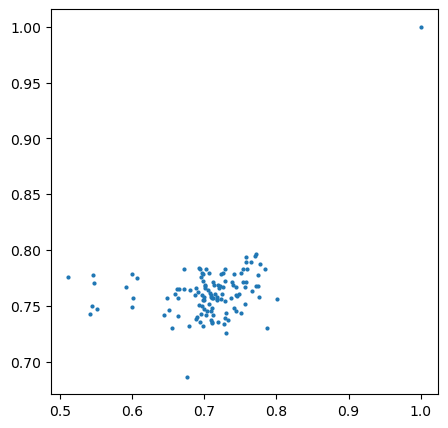

In [4]:
i=3
brngs = os.listdir('HI')
RSX, RSY = 'RSX/' + brngs[i], 'RSY/' + brngs[i]
RSX, RSY = pd.read_csv(RSX), pd.read_csv(RSY)
RSX = RSX['RS'].values
RSY = RSY['RS'].values
plt.figure(figsize=(5, 5))
plt.plot(RSX,RSY,linestyle=' ',linewidth=1, marker='o',markersize = 2)

[1. 1.]
[0.77435845 0.77762397]
[0.80066137 0.75620038]
[0.77160196 0.79691123]
[0.77215583 0.76763109]
[0.75085966 0.77928865]
[0.75408945 0.78338282]
[0.7569893  0.79348831]
[0.75052206 0.743461  ]
[0.77703773 0.78780626]
[0.76466312 0.78935795]
[0.7575459  0.77133095]
[0.66475169 0.76523482]
[0.74726929 0.76061582]
[0.78642921 0.72985286]
[0.78382007 0.7829904 ]
[0.76950234 0.79450224]
[0.69401242 0.78310112]
[0.77570424 0.75840295]
[0.54628266 0.77086931]
[0.74363591 0.7451726 ]
[0.71854587 0.76876555]
[0.71898837 0.7352594 ]
[0.76662484 0.76368227]
[0.75347368 0.77110188]
[0.75727385 0.78929687]
[0.74356665 0.76656215]
[0.77490629 0.76769606]
[0.74537432 0.7589929 ]
[0.74042187 0.74834677]
[0.71177724 0.74227666]
[0.711513   0.77161442]
[0.75654895 0.75160027]
[0.7219616  0.76758853]
[0.51111338 0.77603771]
[0.72797911 0.75475256]
[0.7589892  0.78287289]
[0.70255702 0.74168103]
[0.60683227 0.77498028]
[0.73972301 0.76835373]
[0.69321874 0.73574514]
[0.71684819 0.7555096 ]
[0.72250

C:\Users\claud\AppData\Local\Temp\ipykernel_5340\3292167458.py:109: RuntimeWarning:

invalid value encountered in divide



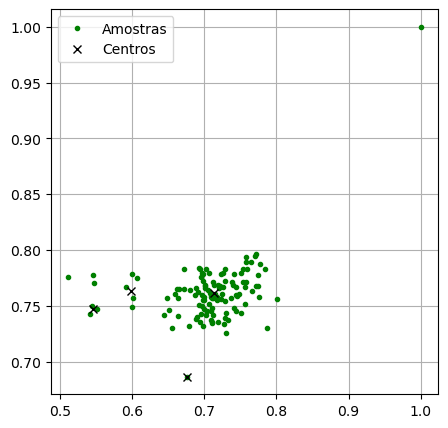

In [58]:
dados = np.array([RSX,RSY])
dados= dados.T
teste=AutoCloud(1.5)
for t in dados:
    teste.run(np.array(t))
plt.rcParams["figure.figsize"] = (5,5)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros'])    
plt.show()

In [53]:
class TEDARegressor:
  def __init__(self,nI,nR,nO,N1,N2,N3,tau,m,eol,fator=1,ep=0.1,wta=False):

    self.g = 1
    self.gCreated = 1
    self.c= np.array([DataCloud(self.gCreated,nI,nR,nO,N1,N2,N3,tau,x=0)],dtype=DataCloud)
    self.alfa= np.array([0.0],dtype=float)
    self.intersection = np.zeros((1,1),dtype=int)
    self.listIntersection = np.zeros((1),dtype=int)
    self.matrixIntersection = np.zeros((1,1),dtype=int)
    self.relevanceList = np.zeros((1),dtype=int)
    self.k=1
    self.m = m
    self.nI = nI
    self.nR = nR
    self.nO = nO
    self.N1 = N1
    self.N2 = N2
    self.N3 = N3
    self.tau = tau
    self.eol = eol
    self.eolX = 0
    self.fator = fator
    self.classIndex = [[1.0],[1.0]]
    self.argMax = []
    self.NumberOfDataClouds = []
    self.cloud_activation = []
    self.cloud_activation2 = []
    self.HI = np.array([])
    self.DSI1 = np.array([])
    self.DSI2 = np.array([])
    self.eolDSI = 0
    self.HIp = np.array([])
    self.cycleP=np.array([])
    self.rulL = np.array([])
    self.rulP = np.array([])
    self.rulU = np.array([])
    self.rulR = None
    self.TL = False
    self.ep = ep
    self.order = 3
    self.ff = 1
    self.df =1
    self.dt=1
    self.rls = RLS_LogarithmicRegressor(0.9,10000)
    #self.rls = RLS_ExponentialRegressor(0.9,10000)
    self.vec = np.array([])
    self.win_all = wta

  def mergeClouds(self):
    i=0
    while(i<len(self.listIntersection)-1):
      merge = False
      j=i+1
      while(j<len(self.listIntersection)):
        if(self.listIntersection[i] == 1 and self.listIntersection[j] == 1):
          self.matrixIntersection[i,j] = self.matrixIntersection[i,j] + 1;
        nI = self.c[i].n
        nJ = self.c[j].n
        meanI = self.c[i].mean
        meanJ = self.c[j].mean
        meantI = self.c[i].meant
        meantJ = self.c[j].meant
        varianceI = self.c[i].variance
        varianceJ = self.c[j].variance
        tipicalityI = self.c[i].tipicality
        tipicalityJ = self.c[j].tipicality
        winI=self.c[i].rnn.w_in
        winJ=self.c[j].rnn.w_in
        wrecI=self.c[i].rnn.w_rec
        wrecJ=self.c[j].rnn.w_rec
        woutI=self.c[i].rnn.w_out
        woutJ=self.c[j].rnn.w_out
        hiI=self.c[i].rnn.hI
        hiJ=self.c[j].rnn.hI
        nIntersc = self.matrixIntersection[i,j]    
        idI = self.c[i].ID
        idJ = self.c[j].ID

        # Check if the intersection value is greater than the difference between n and intersection.
        if(nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
            #print('o merge é possível')
            #print(f'fundiu {idI} com {idJ}')
            #print(f'ni: {nI} nj: {nJ}')
            #print('self.matrixIntersection[i,j]  :',self.matrixIntersection[i,j]    )
            merge = True

            # update values for the new cloud
            n = nI + nJ - nIntersc
            mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
            variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
            meant = ((nI * meantI) + (nJ * meantJ))/(nI + nJ)
            #tipicality = sys.float_info.epsilon
            tipicality = ((nI*tipicalityI)+(nJ*tipicalityJ))/(nI + nJ)
            w_in = ((winI*tipicalityI)+(winJ*tipicalityJ))/(tipicalityI+tipicalityJ)
            w_rec = ((wrecI*tipicalityI)+(wrecJ*tipicalityJ))/(tipicalityI+tipicalityJ)
            w_out = ((woutI*tipicalityI)+(woutJ*tipicalityJ))/(tipicalityI+tipicalityJ)
            hI = ((hiI*tipicalityI)+(hiJ*tipicalityJ))/(tipicalityI+tipicalityJ)

            # create and update new data cloud
            self.gCreated+=1
            newCloud = DataCloud(self.gCreated,self.nI,self.nR,self.nO,self.N1,self.N2,self.N3,self.tau,x=0)
            newCloud.updateDataCloud(n,mean,meant,variance,tipicality)

            # update intersection list and data cloud list
            self.listIntersection = np.concatenate((self.listIntersection[0:i], np.array([1]), self.listIntersection[i+1:j], self.listIntersection[j+1:np.size(self.listIntersection)]), axis=None)
            self.c = np.concatenate((self.c[0:i], np.array([newCloud]), self.c[i+1:j], self.c[j+1:np.size(self.c)]), axis=None)
            self.c[-1].rnn.w_in = w_in
            self.c[-1].rnn.w_rec = w_rec
            self.c[-1].rnn.w_out = w_out
            self.c[-1].rnn.hI = hI
            self.c[-1].merge = f'G{self.gCreated}: G{idI}+G{idJ}'
            # update intersection matrix
            M0 = self.matrixIntersection

            # remove rows
            M1 = np.concatenate((M0[0:i, :], np.zeros((1, len(M0))), M0[i+1:j, :], M0[j+1:len(M0), :]))
            # remove columns
            M1 = np.concatenate((M1[:, 0:i], np.zeros((len(M1), 1)), M1[:, i+1:j], M1[:, j+1:len(M0)]), axis=1)
            # calculate new column
            col = (M0[:, i] + M0[:, j]) * (M0[:, i] * M0[:, j] != 0)
            col = np.concatenate((col[0:j], col[j+1:np.size(col)]))
            # calculate new row
            lin = (M0[i, :] + M0[j, :]) * (M0[i, :] * M0[j, :] != 0)
            lin = np.concatenate((lin[0:j], lin[j+1:np.size(lin)]))
            # update column
            M1[:, i] = col
            # update row
            M1[i, :] = lin
            M1[i, i+1:j] = M0[i, i+1:j] + M0[i+1:j, j].T

            self.matrixIntersection = M1
        j += 1
      if (merge):
        i = 0
      else:
        i += 1
  
  def run(self, x):
    #print(x)
    X = x
    self.listIntersection = np.zeros((np.size(self.c)), dtype=int)
    aux = np.array([])

    if self.k == 1 and not self.TL:
        self.c[0] = DataCloud(self.gCreated,self.nI,self.nR,self.nO,self.N1,self.N2,self.N3,self.tau,x)
        self.argMax.append(0)
        self.listIntersection[0] = 1
        #self.cloud_activation.append(1)
        self.cloud_activation.append(self.c[0].ID)
        aux = np.append(aux,1)


    elif self.k == 2 and not self.TL:
        # Add data point to the existing DataCloud.
        self.c[0].addDataCloud(X)
        self.argMax.append(0)
        self.listIntersection[0] = 1
        #self.cloud_activation.append(1)
        self.cloud_activation.append(self.c[0].ID)
        aux = np.append(aux,1)

    elif self.k >= 3 or self.TL:

        i = 0
        createCloud = True
        self.alfa = np.zeros((np.size(self.c)), dtype=float)

        # Iterate over existing DataCloud instances.
        for cloud in self.c:
            n = cloud.n + 1
            mean = ((n-1)/n) * cloud.mean + (1/n) * X
            meant = ((n-1)/n) * cloud.meant + (X.dot(X))/n
            variance=meant-mean.dot(mean)
            eccentricity = ((1/n) + ((mean-X).T.dot(mean-X)) / (n*variance))
            typicality = (1 - eccentricity)+sys.float_info.epsilon
            norm_eccentricity = eccentricity / 2

            #print('ID', cloud.ID,'X', X,'n', n,'variance', variance,'norm_eccentricity', norm_eccentricity,
            #      'threshold', (self.m**2 + 1) / (2*n), )

            if (n - 2)==0:
               norm_typicality = sys.float_info.epsilon
            else:
              norm_typicality = (typicality / (n - 2))
            if (norm_eccentricity <= (self.m**2 + 1) / (2*n)):
                # If the data point fits inside the DataCloud, update it and set createCloud to False.
                cloud.updateDataCloud(n, mean,meant, variance,typicality)
                self.alfa[i] = norm_typicality
                createCloud = False
                self.listIntersection[i] = 1
                #self.cloud_activation.append(i+1)
                self.cloud_activation.append(cloud.ID)
                aux = np.append(aux,cloud.ID)

            else:
                # If the data point doesn't fit inside the DataCloud, set listIntersection for this index to 0.
                self.alfa[i] = norm_typicality
                self.listIntersection[i] = 0
                cloud.tipicality = typicality
            i += 1
        if (createCloud):
            self.gCreated+=1
            # If none of the existing DataClouds can accommodate the data point, create a new DataCloud instance.
            self.c = np.append(self.c, DataCloud(self.gCreated,self.nI,self.nR,self.nO,self.N1,self.N2,self.N3,self.tau,x))
            wSum=sum([cloud.tipicality for cloud in self.c[:-1]])
            wT = np.array([cloud.tipicality/wSum for cloud in self.c[:-1]])
            

            w_in = self.c[-2].rnn.w_in
            w_rec = self.c[-2].rnn.w_rec
            w_out = self.c[-2].rnn.w_out
            hI = self.c[-2].rnn.hI
            hF = self.c[-2].rnn.hF

            self.c[-1].rnn.w_in = w_in
            self.c[-1].rnn.w_rec = w_rec
            self.c[-1].rnn.w_out = w_out
            self.c[-1].rnn.hI = hI
            self.c[-1].rnn.hF = hF
            self.g = self.g+1
            #self.cloud_activation.append(self.g)
            self.cloud_activation.append(self.c[-1].ID)

            aux = np.append(aux,self.c[-1].ID)
            self.listIntersection = np.insert(self.listIntersection, i, 1)
            self.matrixIntersection = np.pad(self.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0))
        
        self.relevanceList = self.alfa /np.sum(self.alfa)
        self.argMax.append(np.argmax(self.relevanceList))
        self.classIndex.append(self.alfa)
        self.mergeClouds()
        #print('tipicidades:', self.alfa, 'alfa:',2*np.sum(self.alfa)/(len(self.alfa)))
    self.cloud_activation2.append(aux)
    #if self.k>1: #atenção para a contagem da RUL real

       #print('morreu:',self.k, self.eolX-self.nI+1)
    self.cycleP = np.append(self.cycleP,self.nI+self.k-1)
    self.DSI1 = np.append(self.DSI1,X[0])
    self.DSI2 = np.append(self.DSI2,X[1])
    self.k=self.k+1
    self.rulR = np.flip(self.cycleP)-self.nI

In [43]:
i=3
brngs = os.listdir('HI')
RSX, RSY = 'RSX/' + brngs[i], 'RSY/' + brngs[i]
RSX, RSY = pd.read_csv(RSX), pd.read_csv(RSY)
RSX = RSX['RS'].values
RSY = RSY['RS'].values
print(RSX[1],RSY[1])

0.7743584533301755 0.7776239654597236


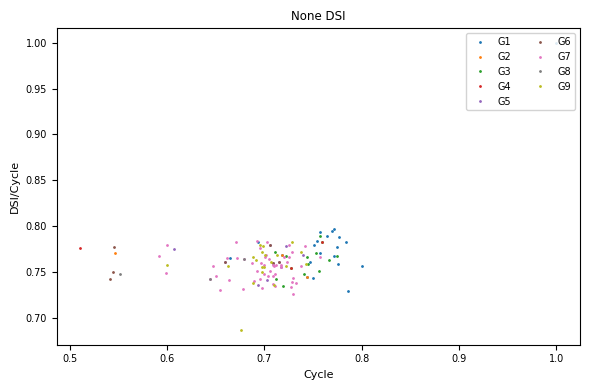

In [56]:
nI,nR,N1,N2,N3,tau,m = [2, 5, 1e-5, 1e-5, 1e-5, 10, 2]
teda = TEDARegressor(nI, nR, nI, N1, N2, N3, tau, m, 0.3, ep=0.1, wta=False)

X = np.array([RS[i:i+nI] for i in range(len(RS)-(nI-1))])
Y = np.array([HI[i:i+nI] for i in range(len(HI)-(nI-1))])
xS = np.array([RSX,RSY]).T
yS = Y[:-1]
zS = Y[1:]

for i in range(len(xS)):
    x, y, z = xS[i], yS[i], zS[i]
    teda.run(x)
    #teda.adapt(y, z)

plot_DSI2(teda)

In [65]:
class DataCloud3:
	N=0
	def __init__(self,x):
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

class AutoCloud3:
	def __init__(self, m):
			self.g = 1
			self.gCreated = 1
			self.c= np.array([DataCloud3(0)],dtype=DataCloud3)
			self.alfa= np.array([0.0],dtype=float)
			self.intersection = np.zeros((1,1),dtype=int)
			self.listIntersection = np.zeros((1),dtype=int)
			self.matrixIntersection = np.zeros((1,1),dtype=int)
			self.relevanceList = np.zeros((1),dtype=int)
			self.classIndex = []
			self.k=1
			self.m = m
		
	def mergeClouds(self):
		i=0
		while(i<len(self.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(self.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(self.listIntersection[i] == 1 and self.listIntersection[j] == 1):
					self.matrixIntersection[i,j] = self.matrixIntersection[i,j] + 1;
				nI = self.c[i].n
				nJ = self.c[j].n
				meanI = self.c[i].mean
				meanJ = self.c[j].mean
				varianceI = self.c[i].variance
				varianceJ = self.c[j].variance
				nIntersc = self.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud3(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					self.listIntersection = np.concatenate((self.listIntersection[0 : i], np.array([1]), self.listIntersection[i + 1 : j],self.listIntersection[j + 1 : np.size(self.listIntersection)]),axis=None)
					#atualizando lista de data clouds 
					self.c = np.concatenate((self.c[0 : i ], np.array([newCloud]), self.c[i + 1 : j],self.c[j + 1 : np.size(self.c)]),axis=None)
					#update  intersection matrix
					M0 = self.matrixIntersection
					#Remover linhas 
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					self.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X):
		print(X)
		self.listIntersection = np.zeros((np.size(self.c)),dtype=int)
		if self.k==1:
			self.c[0]=DataCloud3(X)
			self.classIndex.append(0)
		elif self.k==2:
			self.c[0].addDataClaud(X)
			self.classIndex.append(0)
		elif self.k>=3:
			i=0
			createCloud = True
			self.alfa = np.zeros((np.size(self.c)),dtype=float)
			for data in self.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(self.k-2)
				data.eccAn = eccentricity
				if(norm_eccentricity<=(self.m**2 +1)/(2*n)):
					data.updateDataCloud(n,mean,variance)
					self.alfa[i] = norm_typicality
					createCloud= False
					self.listIntersection.itemset(i,1)
				else:
					self.alfa[i] = 0
					self.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				self.c = np.append(self.c,DataCloud3(X))
				self.listIntersection = np.insert(self.listIntersection,i,1)
				self.matrixIntersection = np.pad(self.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
			self.mergeClouds()
			self.relevanceList = self.alfa /np.sum(self.alfa)
			classIndex = np.argmax(self.relevanceList)
			self.classIndex.append(classIndex)

        
		self.k=self.k+1


[1. 1.]
[0.77435845 0.77762397]
[0.80066137 0.75620038]
[0.77160196 0.79691123]
[0.77215583 0.76763109]
[0.75085966 0.77928865]
[0.75408945 0.78338282]
[0.7569893  0.79348831]
[0.75052206 0.743461  ]
[0.77703773 0.78780626]
[0.76466312 0.78935795]
[0.7575459  0.77133095]
[0.66475169 0.76523482]
[0.74726929 0.76061582]
[0.78642921 0.72985286]
[0.78382007 0.7829904 ]
[0.76950234 0.79450224]
[0.69401242 0.78310112]
[0.77570424 0.75840295]
[0.54628266 0.77086931]
[0.74363591 0.7451726 ]
[0.71854587 0.76876555]
[0.71898837 0.7352594 ]
[0.76662484 0.76368227]
[0.75347368 0.77110188]
[0.75727385 0.78929687]
[0.74356665 0.76656215]
[0.77490629 0.76769606]
[0.74537432 0.7589929 ]
[0.74042187 0.74834677]
[0.71177724 0.74227666]
[0.711513   0.77161442]
[0.75654895 0.75160027]
[0.7219616  0.76758853]
[0.51111338 0.77603771]
[0.72797911 0.75475256]
[0.7589892  0.78287289]
[0.70255702 0.74168103]
[0.60683227 0.77498028]
[0.73972301 0.76835373]
[0.69321874 0.73574514]
[0.71684819 0.7555096 ]
[0.72250

C:\Users\claud\AppData\Local\Temp\ipykernel_5340\1882919075.py:120: RuntimeWarning:

invalid value encountered in divide



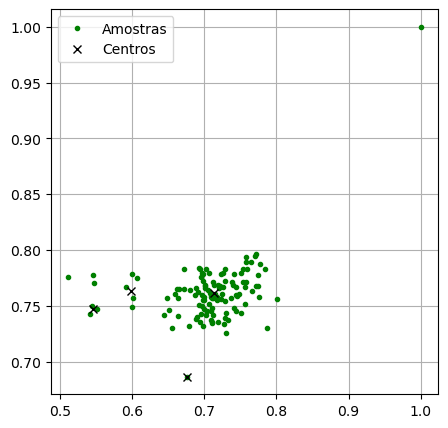

In [64]:
dados = np.array([RSX,RSY])
dados= dados.T
teste=AutoCloud3(1.5)
for t in dados:
    teste.run(np.array(t))
plt.rcParams["figure.figsize"] = (5,5)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros'])    
plt.show()